In [1]:
import os,re
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras import backend as K
from collections import Counter
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from itertools import cycle
import Function
import Encoding
from tensorflow.keras.layers import Layer

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

def save_result(cv_res, ind_res, outPath, codename):
    mkdir(outPath)
    out = os.path.join(outPath, codename.lower())
    Function.save_predict_result(cv_res, out + '_pre_cv.txt')
    cv_meanauc, cv_auc = Function.plot_roc_curve(cv_res, out + '_roc_cv.png', label_column=0, score_column=2)
    cv_meanprc, cv_prc = Function.plot_prc_curve(cv_res, out + '_prc_cv.png', label_column=0, score_column=2)
    cv_metrics = Function.calculate_metrics_list(cv_res, label_column=0, score_column=2, cutoff=0.5, po_label=1)
    Function.save_prediction_metrics_list(cv_metrics, out + '_metrics_cv.txt')
    Function.save_predict_result(ind_res, out + '_pre_ind.txt')
    ind_meanauc, ind_auc = Function.plot_roc_curve(ind_res, out + '_roc_ind.png', label_column=0, score_column=2)
    ind_meanprc, ind_prc = Function.plot_prc_curve(ind_res, out + '_prc_ind.png', label_column=0, score_column=2)
    ind_metrics = Function.calculate_metrics_list(ind_res, label_column=0, score_column=2, cutoff=0.5, po_label=1)
    Function.save_prediction_metrics_list(ind_metrics, out + '_metrics_ind.txt')
    return None

# Create folder
def mkdir(path):
    path=path.strip()
    path=path.rstrip("\\")
    # Check if the path exists
    isExists=os.path.exists(path)
    if not isExists:
        # Create the directory if it doesn't exist
        os.makedirs(path)
    else:
        # Do not create directory if it exists
        pass

def res_net_block(input_data, filters, strides=1):
    x = layers.Conv1D(filters, kernel_size=3, strides=strides, padding='same')(input_data)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    if strides != 1:
        downsample = layers.Conv1D(filters, kernel_size=1, strides=strides)(input_data)
    else:  
        downsample = input_data
    x = layers.Add()([x, downsample])
    output = layers.Activation('relu')(x)

    return output

# CNN-based classifiers
def CNNbasic(Encode):
    inputs = tf.keras.Input(shape=(Encode.shape[1], Encode.shape[2]))
    
    x = layers.Conv1D(128, kernel_size=3)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool1D(pool_size=2, strides=1, padding='same')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv1D(128, kernel_size=3)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool1D(pool_size=2, strides=1, padding='same')(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=tf.nn.relu, kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dense(64, activation=tf.nn.relu, kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    output = layers.Dense(1, activation=tf.nn.sigmoid)(x)
    DeepSUMO = Model(inputs=[inputs], outputs=[output], name="DeepSUMO")
    DeepSUMO.summary()
    DeepSUMO.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  experimental_run_tf_function=False)
    return DeepSUMO

In [3]:
parent_dir = os.path.abspath(os.path.dirname(os.getcwd()))

In [4]:
trainfilepath = os.path.join(parent_dir, r'Data\five_fold_cross_validation.csv')
testfilepath = os.path.join(parent_dir, r'Data\independent.csv')

In [7]:
ZScale, y = Encoding.ZScale(trainfilepath, 1)
zscale_test, y_test = Encoding.ZScale(testfilepath, 1)

In [8]:
ZScale.shape

(67090, 39, 5)

In [9]:
zscale_test.shape

(7456, 39, 5)

In [10]:
y_test

array([1., 1., 1., ..., 0., 0., 0.])

In [3]:
# The residual structure layered CNN architecture (RSCNN)
def RSCNN(Encode):
    
    inputs = tf.keras.Input(shape=(Encode.shape[1], Encode.shape[2]))
    x = layers.Conv1D(128, kernel_size=3)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPool1D(pool_size=2, strides=1, padding='same')(x)
    x = layers.Dropout(0.5)(x)
    
    x = res_net_block(x, 128)
    x = layers.MaxPool1D(2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = res_net_block(x, 128)
    x = layers.MaxPool1D(2)(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation=tf.nn.relu, kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)
    x = layers.Dense(64, activation=tf.nn.relu, kernel_regularizer = tf.keras.regularizers.l2(0.01))(x)

    output = layers.Dense(1, activation=tf.nn.sigmoid)(x)
    DeepSUMO = Model(inputs=[inputs1], outputs=[output], name="DeepSUMO")
    DeepSUMO.summary()
    DeepSUMO.compile(optimizer=optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'],
                  experimental_run_tf_function=False)
    return DeepSUMO

In [ ]:
def train():
    suboutput = os.path.join(parent_dir, 'Results')
    mkdir(suboutput)
    prediction_result_cv = []
    prediction_result_ind = []
    Code_Name = 'RSCNN_ZScale'
    file_Name = 'zscale'
    outputs = os.path.join(suboutput, Code_Name)
    mkdir(outputs)
    folds = StratifiedKFold(5).split(ZScale, y)
    for i, (train, valid) in enumerate(folds):
        train_x, train_y = ZScale[train], y[train]
        valid_x, valid_y = ZScale[valid], y[valid]
        modelName = 'model' + str(i+1) + '.h5'
        filepath = os.path.join(outputs, modelName)
        network = RSCNN(train_x)
        best_saving = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy',mode='auto',
                                                                 verbose=1, save_best_only=True, save_weights_only=True)
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)
        history = network.fit(train_x, train_y, validation_data=(valid_x, valid_y), epochs=500, batch_size=128,
                            shuffle=True, callbacks=[best_saving, early_stopping], verbose=1)

        network.load_weights(filepath)
        tmp_result = np.zeros((len(valid_y), len(categories) + 1))
        tmp_result[:, 0], tmp_result[:, 1:] = valid_y, network.predict(valid_x)
        prediction_result_cv.append(tmp_result)

        tmp_result1 = np.zeros((len(y_test), len(categories) + 1))
        tmp_result1[:, 0], tmp_result1[:, 1:] = y_test, network.predict(zscale_test)
        prediction_result_ind.append(tmp_result1)

    save_result(prediction_result_cv, prediction_result_ind, outputs, file_Name)
        
    return None

In [ ]:
flag = train()

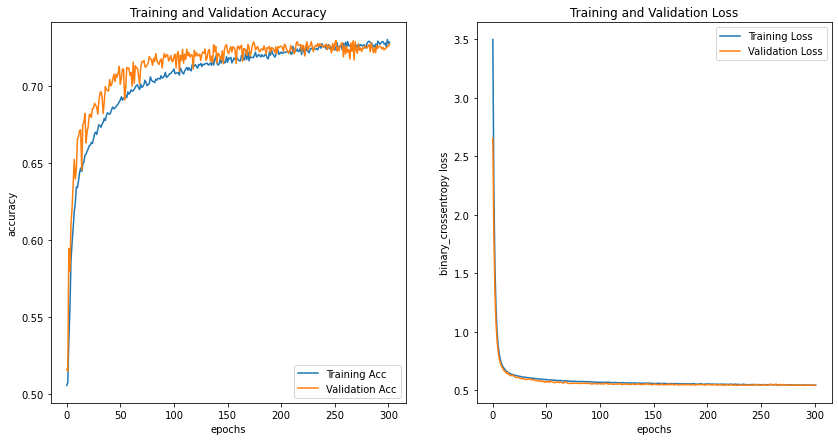

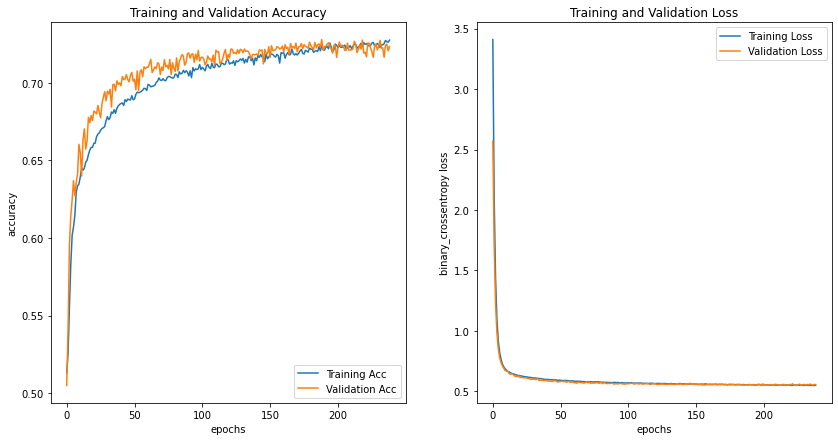

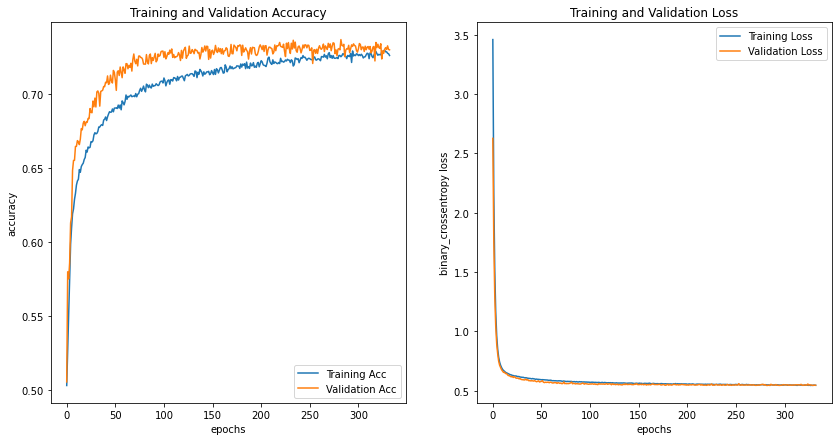

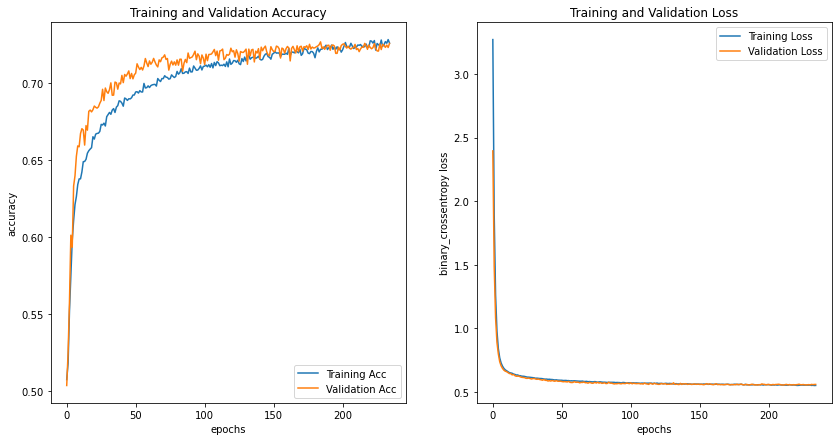

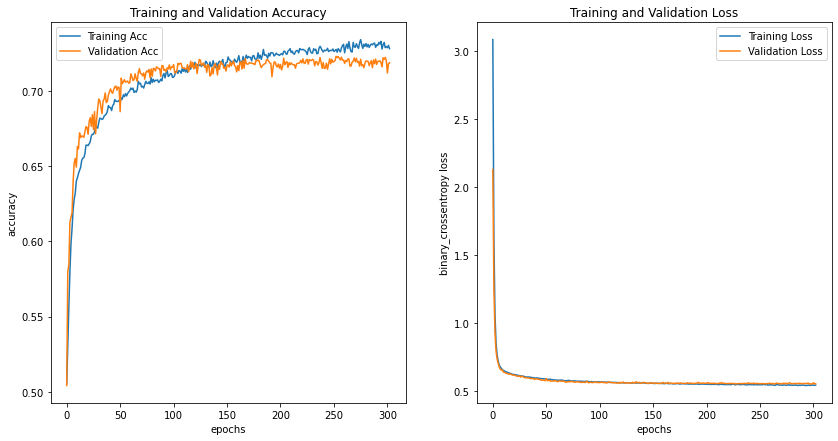

In [8]:
for i in range(5):
    history = flag[i]
    plt.figure(figsize=(14, 7))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=None)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.ylabel('binary_crossentropy loss')
    plt.xlabel('epochs')
    plt.legend()
    plt.show()